# Алгоритмы безусловной нелинейной оптимизации. Стохастические и метаэвристические алгоритмы

$$y_k = \begin{cases}
-10 + \delta_k, & \text{$f(x_k)<-10^2$;} \\
f(x_k) + \delta_k, & \text{$\left|f(x_k)\right|\le10^2$;} & x_k=\dfrac{3k}{10^3}, & f(x)=\dfrac{1}{x^2-3x+2}, & k=0\dots10^3, & \delta_k \sim N(0,1)\\
10^2 + \delta_k, & \text{$f(x_k)>10^2$;} \\
\end{cases}
$$

In [378]:
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, minimize, dual_annealing
import pandas as pd
import seaborn as sns
import re
import math as m
from simanneal import Annealer
from collections import defaultdict

## Data Generation

In [369]:
def f(x):
    if x != 2 and x != 1:
        return 1/(x ** 2 - 3 * x + 2)
    else:
        return 1000000

In [370]:
n = 1000
x = [3 * i /1000 for i in range(n)]
y_init = []
y = []
eps = 1e-3
accuracy = round(m.log(1/eps, 10))

for i in x:
    if f(i) < -100:
        y.append(-10 + random.normalvariate(0, 1))
        y_init.append(-10)
    elif abs(f(i)) <= 100:
        y.append(f(i) + random.normalvariate(0, 1))
        y_init.append(f(i))
    elif f(i) >= 100:
        y.append(100 + random.normalvariate(0, 1))
        y_init.append(100)

In [371]:
def visualise_2d(predict):
    dpi = 80
    fig = plt.figure(dpi=dpi, figsize=(1024 / dpi, 512 / dpi))
    plt.scatter(x=x, y=y, c='r', s=1, label = "data generated") 
    
    for method in predict.keys():
        print(method, predict[method], least_squares_f(predict[method][0], predict[method][1], predict[method][2], predict[method][3]))
        y_t = [f_approx(i, predict[method][0], predict[method][1], predict[method][2], predict[method][3]) for i in x]
        plt.plot(x, y_t, label=method)
    
    plt.plot(x, y_init, label="init line", linestyle = '--')
    
    plt.title("Results")
    plt.grid(True)
    plt.legend()
    
    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.show()

In [372]:
def f_approx(x, a, b, c, d):
    if x ** 2 + c * x + d != 0:
        return (a * x + b) / (x ** 2 + c * x + d)
    else: 
        return 1000000

In [373]:
def least_squares_f(a, b, c, d):
    d_sum = 0
    for i in range(n):
        d_sum += (f_approx(x[i], a, b, c, d) - y[i]) ** 2
    return d_sum

## Part 1

### Nelder Mead

In [374]:
def least_squares_np(v):
    d_sum = 0
    for i in range(n):
        d_sum += (f_approx(x[i], v[0], v[1], v[2], v[3]) - y[i]) ** 2
    return d_sum

x0 = np.array([2, 2, 2, 2])
options = {
    'maxiter': 1000,
    'xatol': eps
}
nm = minimize(least_squares_np, x0, args=(), method='Nelder-Mead', options=options)
print(nm)
print(f"nfev = {nm.nfev}")
print(f"[a, b, c, d] = {nm.x}")

 final_simplex: (array([[-1.10530359,  1.10874649, -2.00163266,  1.00168468],
       [-1.10532831,  1.10877147, -2.00163326,  1.00168529],
       [-1.10532951,  1.10877245, -2.00163247,  1.00168449],
       [-1.10534569,  1.10878912, -2.00163337,  1.00168539],
       [-1.1053245 ,  1.10876774, -2.00163306,  1.00168508]]), array([110833.07277348, 110833.07278561, 110833.07282792, 110833.07283621,
       110833.07285184]))
           fun: 110833.07277348301
       message: 'Optimization terminated successfully.'
          nfev: 563
           nit: 331
        status: 0
       success: True
             x: array([-1.10530359,  1.10874649, -2.00163266,  1.00168468])
nfev = 563
[a, b, c, d] = [-1.10530359  1.10874649 -2.00163266  1.00168468]


### Levenberg-Marquardt algorithm

In [375]:
def least_squares_lm(v, x, y):
    return (v[0] * x + v[1]) / (x ** 2 + v[2] * x + v[3]) - y

x0 = np.array([2, 2, 2, 2])
lma = least_squares(least_squares_lm, x0, method="lm", args=(np.array(x), np.array(y)), xtol=eps)

# в зависимости от точности дает данные разного качества
# print(lma)
print(f"nfev = {lma.nfev}")
print(f"[a, b, c, d] = {lma.x}")

nfev = 70
[a, b, c, d] = [-1.74671228  1.73077238 -2.00976008  1.0277774 ]


### Simulated Annealing

In [389]:
sim_an = dual_annealing(least_squares_np, bounds=list(zip([-2]*4, [2]*4)))
sim_an

     fun: 111129.0308768572
 message: ['Maximum number of iteration reached']
    nfev: 8801
    nhev: 0
     nit: 1000
    njev: 160
  status: 0
 success: True
       x: array([-1.07194146,  1.0748542 , -2.        ,  1.00004963])

### Differential Evolution or Particle Swarm Optimization

### Visualise

Levenberg-Marquardt algorithm [-1.74671228  1.73077238 -2.00976008  1.0277774 ] 194913.57492234863
Nelder Mead [-1.10530359  1.10874649 -2.00163266  1.00168468] 110833.07277348301
Simulated Annealing [-1.07194146  1.0748542  -2.          1.00004963] 111129.0308768572


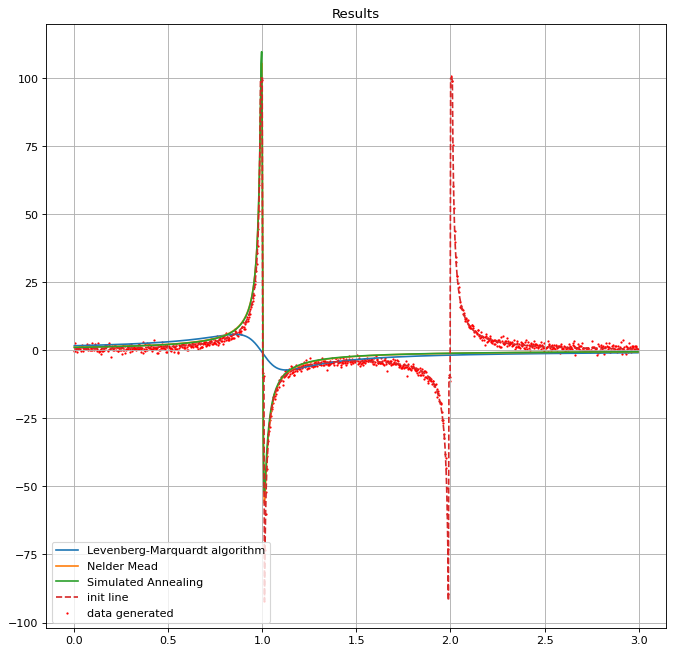

In [390]:
predict_a_b = {
    "Levenberg-Marquardt algorithm": lma.x,
    "Nelder Mead": nm.x,
    "Simulated Annealing": sim_an.x
    
}
visualise_2d(predict_a_b)

# Part 2

In [364]:
file_name = open("/Users/emidiant/Desktop/ITMO/Магистратура/1 семестр/Анализ и разработка алгоритмов/Task 4/usca312_name.txt")
file_dist = open("/Users/emidiant/Desktop/ITMO/Магистратура/1 семестр/Анализ и разработка алгоритмов/Task 4/usca312_dist.txt")
file_xy = open("/Users/emidiant/Desktop/ITMO/Магистратура/1 семестр/Анализ и разработка алгоритмов/Task 4/usca312_xy.txt")
num_cities = 15
full_amount = 315
num_lines = 315 // 10 + 1
cities_dists = []
row = ""
for x in file_dist:
    if x[0] != "#":
        x = x.strip()
        x = re.sub(" +", " ", x)
        row += x + " "
        num_lines -= 1
        if num_lines == 0:
            num_lines = 315 // 10 + 1
            list_row = row.split()
            list_row = list(map(int, list_row))
            cities_dists.append(list_row[:num_cities])
            row = ""
    if len(cities_dists) == 15: 
        break
cities_names = []    
for x in file_name:
    if x[0] != "#":
        cities_names.append(x.rstrip())
    if len(cities_names) >= 15:
        break
count = 0
cities_coord = {}
for x in file_xy:
    if x[0] != "#":
        list_xy = list(map(float, x.rstrip().split()))
        cities_coord[cities_names[count]] = (list_xy[0], list_xy[1])
        count += 1
    if count == 15:
        break

In [272]:
df = pd.DataFrame(cities_dists, columns=cities_names, index=cities_names)
df

,"Abilene, TX","Akron, OH","Albany, NY","Albuquerque, NM","Alert, NT","Allentown, PA","Amarillo, TX","Anchorage, AK","Ann Arbor, MI","Asheville, NC","Ashland, KY","Atlanta, GA","Atlantic City, NJ","Augusta, GA","Augusta, ME"
"Abilene, TX",0,1167,1579,437,3575,1453,226,2976,1107,1006,1046,891,1488,1030,1803
"Akron, OH",1167,0,413,1422,2895,316,1172,3094,140,382,189,530,392,526,635
"Albany, NY",1579,413,0,1832,2766,167,1585,3265,508,677,547,842,229,775,229
"Albuquerque, NM",437,1422,1832,0,3437,1732,272,2607,1327,1355,1345,1269,1787,1409,2041
"Alert, NT",3575,2895,2766,3437,0,2911,3397,2028,2821,3277,3079,3411,2994,3422,2645
"Allentown, PA",1453,316,167,1732,2911,0,1477,3318,441,516,408,680,102,608,387
"Amarillo, TX",226,1172,1585,272,3397,1477,0,2749,1087,1084,1082,997,1527,1137,1800
"Anchorage, AK",2976,3094,3265,2607,2028,3318,2749,0,2958,3359,3198,3402,3421,3498,3304
"Ann Arbor, MI",1107,140,508,1327,2821,441,1087,2958,0,465,268,589,525,615,714
"Asheville, NC",1006,382,677,1355,3277,516,1084,3359,465,0,198,165,515,150,903


In [351]:
def draw_way(state):
    dpi = 80
    fig = plt.figure(dpi=dpi, figsize=(1024 / dpi, 512 / dpi))
    for city in cities_coord.keys():
        x_i, y_i = cities_coord[city]
        plt.scatter(x_i, y_i, c='r', s=7) 
        plt.text(x_i - len(city) * 25, y_i + 30, city)

    dist = 0
    for i in range(len(state)):
        j = (i + 1) % len(state)
        print(state[i], "➞", state[j])
        print(cities_coord[state[i]], cities_coord[state[j]], df[state[i]][state[j]])
        x1, y1 = cities_coord[state[i]]
        x2, y2 = cities_coord[state[j]]
        plt.plot([x1, x2], [y1, y2])
        dist += df[state[i]][state[j]]

    print("dist =", dist)

    plt.title("Map")
    plt.grid(True)

    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.show()

In [360]:
class TravellingSalesmanProblem(Annealer):

    def __init__(self, state, distance_matrix):
        self.distance_matrix = distance_matrix
        super(TravellingSalesmanProblem, self).__init__(state)
        self.count = 0
        self.start_state = []

    def move(self):
        """Swaps two cities in the route."""
        initial_energy = self.energy()

        a = random.randint(0, len(self.state) - 1)
        b = random.randint(0, len(self.state) - 1)
        self.state[a], self.state[b] = self.state[b], self.state[a]

        return self.energy() - initial_energy

    def energy(self):
        """Calculates the length of the route."""
        e = 0
        for i in range(len(self.state)):
            e += self.distance_matrix[self.state[i-1]][self.state[i]]
        if self.count == 0:
            self.start_state = self.state
        self.count += 1
        return e


if __name__ == '__main__':
    distance_matrix = defaultdict(dict)
    for ka in cities_names:
        for kb in cities_names:
            distance_matrix[ka][kb] = df[ka][kb]
            
    random.shuffle(cities_names)

    tsp = TravellingSalesmanProblem(cities_names, distance_matrix)
    tsp.set_schedule(tsp.auto(minutes=0.2))
    # since our state is just a list, slice is the fastest way to copy
    tsp.copy_strategy = "slice"
    state, e = tsp.anneal()

    while state[0] != 'Abilene, TX':
        state = state[1:] + state[:1] 
        
    start_state = tsp.start_state
    print(" ➞  ".join(start_state))

    print("count:", tsp.count)
    print
    print(f"{e} mile route:")
    print(" ➞  ".join(state))

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     7.30000      10441.00     6.65%     0.00%     0:00:03    -1:59:59 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     7.30000      10441.00     6.96%     0.21%     0:00:07     0:00:00

Anchorage, AK ➞  Asheville, NC ➞  Ashland, KY ➞  Atlantic City, NJ ➞  Augusta, ME ➞  Atlanta, GA ➞  Albuquerque, NM ➞  Akron, OH ➞  Allentown, PA ➞  Albany, NY ➞  Alert, NT ➞  Augusta, GA ➞  Ann Arbor, MI ➞  Amarillo, TX ➞  Abilene, TX
count: 690040
10441 mile route:
Abilene, TX ➞  Atlanta, GA ➞  Augusta, GA ➞  Asheville, NC ➞  Ashland, KY ➞  Ann Arbor, MI ➞  Akron, OH ➞  Allentown, PA ➞  Atlantic City, NJ ➞  Albany, NY ➞  Augusta, ME ➞  Alert, NT ➞  Anchorage, AK ➞  Albuquerque, NM ➞  Amarillo, TX


Abilene, TX ➞ Atlanta, GA
(-6890.91, 2242.06) (-5830.85, 2331.9) 891
Atlanta, GA ➞ Augusta, GA
(-5830.85, 2331.9) (-5664.12, 2312.69) 140
Augusta, GA ➞ Asheville, NC
(-5664.12, 2312.69) (-5704.14, 2459.86) 150
Asheville, NC ➞ Ashland, KY
(-5704.14, 2459.86) (-5709.93, 2658.69) 198
Ashland, KY ➞ Ann Arbor, MI
(-5709.93, 2658.69) (-5785.13, 2920.73) 268
Ann Arbor, MI ➞ Akron, OH
(-5785.13, 2920.73) (-5632.62, 2838.55) 140
Akron, OH ➞ Allentown, PA
(-5632.62, 2838.55) (-5216.07, 2805.86) 316
Allentown, PA ➞ Atlantic City, NJ
(-5216.07, 2805.86) (-5142.33, 2719.89) 102
Atlantic City, NJ ➞ Albany, NY
(-5142.33, 2719.89) (-5096.27, 2947.1) 229
Albany, NY ➞ Augusta, ME
(-5096.27, 2947.1) (-4821.5, 3061.67) 229
Augusta, ME ➞ Alert, NT
(-4821.5, 3061.67) (-4303.32, 5701.62) 2645
Alert, NT ➞ Anchorage, AK
(-4303.32, 5701.62) (-10357.5, 4229.9) 2028
Anchorage, AK ➞ Albuquerque, NM
(-10357.5, 4229.9) (-7369.09, 2424.18) 2607
Albuquerque, NM ➞ Amarillo, TX
(-7369.09, 2424.18) (-7036.07, 2433.68) 27

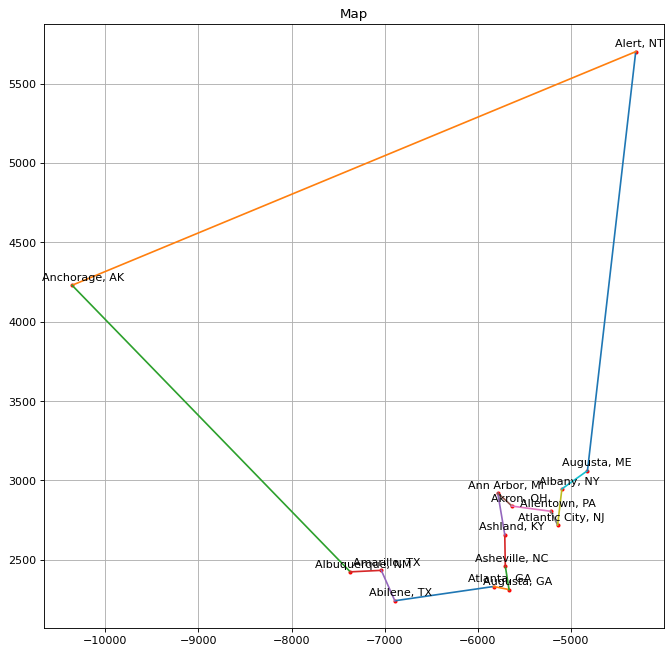

In [361]:
draw_way(state)

Anchorage, AK ➞ Asheville, NC
(-10357.5, 4229.9) (-5704.14, 2459.86) 3359
Asheville, NC ➞ Ashland, KY
(-5704.14, 2459.86) (-5709.93, 2658.69) 198
Ashland, KY ➞ Atlantic City, NJ
(-5709.93, 2658.69) (-5142.33, 2719.89) 445
Atlantic City, NJ ➞ Augusta, ME
(-5142.33, 2719.89) (-4821.5, 3061.67) 416
Augusta, ME ➞ Atlanta, GA
(-4821.5, 3061.67) (-5830.85, 2331.9) 1068
Atlanta, GA ➞ Albuquerque, NM
(-5830.85, 2331.9) (-7369.09, 2424.18) 1269
Albuquerque, NM ➞ Akron, OH
(-7369.09, 2424.18) (-5632.62, 2838.55) 1422
Akron, OH ➞ Allentown, PA
(-5632.62, 2838.55) (-5216.07, 2805.86) 316
Allentown, PA ➞ Albany, NY
(-5216.07, 2805.86) (-5096.27, 2947.1) 167
Albany, NY ➞ Alert, NT
(-5096.27, 2947.1) (-4303.32, 5701.62) 2766
Alert, NT ➞ Augusta, GA
(-4303.32, 5701.62) (-5664.12, 2312.69) 3422
Augusta, GA ➞ Ann Arbor, MI
(-5664.12, 2312.69) (-5785.13, 2920.73) 615
Ann Arbor, MI ➞ Amarillo, TX
(-5785.13, 2920.73) (-7036.07, 2433.68) 1087
Amarillo, TX ➞ Abilene, TX
(-7036.07, 2433.68) (-6890.91, 2242.06

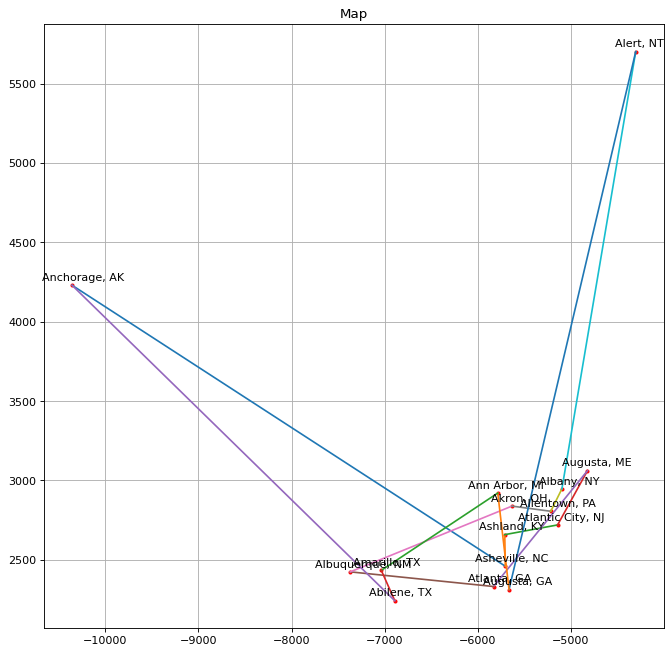

In [362]:
draw_way(start_state)